In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.datasets import load_breast_cancer, make_classification

In [21]:
# A simple Particle Swarm Optimization (PSO) implementation
class ParticleSwarmOptimization:
    def __init__(self, objective_function, dimensions, bounds, 
                 num_particles=20, max_iterations=50, w=0.7, c1=1.5, c2=1.5):
        self.objective_function = objective_function
        self.dimensions = dimensions
        self.bounds = bounds
        self.num_particles = num_particles
        self.max_iterations = max_iterations
        self.w = w
        self.c1 = c1
        self.c2 = c2

        # Initialize particle positions and velocities
        self.positions = np.random.uniform(bounds[0], bounds[1], (num_particles, dimensions))
        self.velocities = np.random.uniform(-abs(bounds[1]-bounds[0]), abs(bounds[1]-bounds[0]), 
                                            (num_particles, dimensions))
        self.personal_best_positions = self.positions.copy()
        self.personal_best_values = np.array([self.objective_function(pos) for pos in self.positions])
        best_idx = np.argmin(self.personal_best_values)
        self.global_best_position = self.personal_best_positions[best_idx].copy()
        self.global_best_value = self.personal_best_values[best_idx]
        self.global_best_history = [self.global_best_value]

    def optimize(self):
        for iter in range(self.max_iterations):
            for i in range(self.num_particles):
                r1 = np.random.rand(self.dimensions)
                r2 = np.random.rand(self.dimensions)
                # Update velocity
                self.velocities[i] = (self.w * self.velocities[i] +
                                      self.c1 * r1 * (self.personal_best_positions[i] - self.positions[i]) +
                                      self.c2 * r2 * (self.global_best_position - self.positions[i]))
                # Update position
                self.positions[i] = self.positions[i] + self.velocities[i]
                # Clamp positions to bounds
                self.positions[i] = np.clip(self.positions[i], self.bounds[0], self.bounds[1])
                # Evaluate objective function
                value = self.objective_function(self.positions[i])
                # Update personal best if needed
                if value < self.personal_best_values[i]:
                    self.personal_best_values[i] = value
                    self.personal_best_positions[i] = self.positions[i].copy()
                    # Update global best if needed
                    if value < self.global_best_value:
                        self.global_best_value = value
                        self.global_best_position = self.positions[i].copy()
            self.global_best_history.append(self.global_best_value)
        return self.global_best_position, self.global_best_value

In [24]:
def breast_cancer_feature_selection():
    """Demonstrate PSO for feature selection with visualization"""
    try:
        # Attempt to load a dataset
        dataset = load_breast_cancer()
        X, y = dataset.data, dataset.target
        feature_names = dataset.feature_names
        print("Using Breast Cancer dataset for feature selection")
    except Exception as e:
        print("Error loading Breast Cancer dataset:", e)
        # Fallback to a simple synthetic dataset
        X, y = make_classification(n_samples=500, n_features=20, n_informative=10,
                                   random_state=42)
        feature_names = [f"Feature {i}" for i in range(X.shape[1])]
        print("Using synthetic dataset for feature selection")
    
    print("-" * 50)
    print(f"Dataset shape: {X.shape}")
    print(f"Number of features: {X.shape[1]}")
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Define the objective function for PSO
    def evaluate_features(position):
        """Evaluate a feature subset by training a classifier and measuring accuracy"""
        # Binarize position to determine which features to use
        features_to_use = position > 0.5
        
        # If no features are selected, return a high cost
        if not np.any(features_to_use):
            return 1.0
        
        # Select features from training and test sets
        X_train_selected = X_train[:, features_to_use]
        X_test_selected = X_test[:, features_to_use]
        
        # Train a simple classifier
        clf = KNeighborsClassifier(n_neighbors=3)
        clf.fit(X_train_selected, y_train)
        
        # Predict and calculate error (1 - accuracy)
        y_pred = clf.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Add a penalty for using too many features
        n_features_used = np.sum(features_to_use)
        penalty = 0.01 * n_features_used / X.shape[1]
        
        # We want to minimize error, so return 1-accuracy plus the penalty
        return 1.0 - accuracy + penalty
    
    # Run PSO for feature selection
    print("Starting PSO for feature selection...")
    pso = ParticleSwarmOptimization(
        objective_function=evaluate_features,
        dimensions=X.shape[1],
        bounds=(0, 1),
        num_particles=20,
        max_iterations=50,
        w=0.7,
        c1=1.5,
        c2=1.5
    )
    
    best_position, best_value = pso.optimize()
    
    # Convert the best continuous position to a binary feature selection mask
    selected_features = best_position > 0.5
    n_selected = np.sum(selected_features)
    
    print(f"Optimization complete. Selected {n_selected} out of {X.shape[1]} features.")
    print(f"Best cost (error + penalty): {best_value:.4f}")
    
    # Train classifier with selected features and evaluate performance
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]
    
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)
    final_accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with selected features: {final_accuracy:.4f}")
    
    # Compare with using all features
    clf_all = KNeighborsClassifier(n_neighbors=3)
    clf_all.fit(X_train, y_train)
    y_pred_all = clf_all.predict(X_test)
    accuracy_all = accuracy_score(y_test, y_pred_all)
    print(f"Accuracy with all features: {accuracy_all:.4f}")
    
    # Visualize feature importance and selection
    plt.figure(figsize=(12, 6))
    importance = np.zeros(X.shape[1])
    importance[selected_features] = abs(best_position[selected_features])
    
    # Sort features by importance
    sorted_idx = np.argsort(importance)
    sorted_names = np.array(feature_names)[sorted_idx]
    sorted_importance = importance[sorted_idx]
    
    plt.barh(range(len(sorted_names)), sorted_importance, align='center')
    plt.yticks(range(len(sorted_names)), sorted_names)
    plt.xlabel('Feature Importance')
    plt.title('PSO Feature Selection Results')
    plt.tight_layout()
    plt.show()
    
    # Plot convergence history
    plt.figure(figsize=(10, 5))
    plt.plot(pso.global_best_history, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Cost (Error + Penalty)')
    plt.title('PSO Convergence for Feature Selection')
    plt.grid(True)
    plt.show()
    
    # Show correlation matrix of selected features if more than one feature was selected
    if n_selected > 1:
        plt.figure(figsize=(10, 8))
        selected_feature_names = np.array(feature_names)[selected_features]
        X_selected = X[:, selected_features]
        corr_matrix = np.corrcoef(X_selected.T)
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                    xticklabels=selected_feature_names, yticklabels=selected_feature_names)
        plt.title("Correlation Matrix of Selected Features")
        plt.tight_layout()
        plt.show()
    
    return selected_features, feature_names

Using Breast Cancer dataset for feature selection
--------------------------------------------------
Dataset shape: (569, 30)
Number of features: 30
Starting PSO for feature selection...
Optimization complete. Selected 10 out of 30 features.
Best cost (error + penalty): 0.0326
Accuracy with selected features: 0.9708
Accuracy with all features: 0.9415


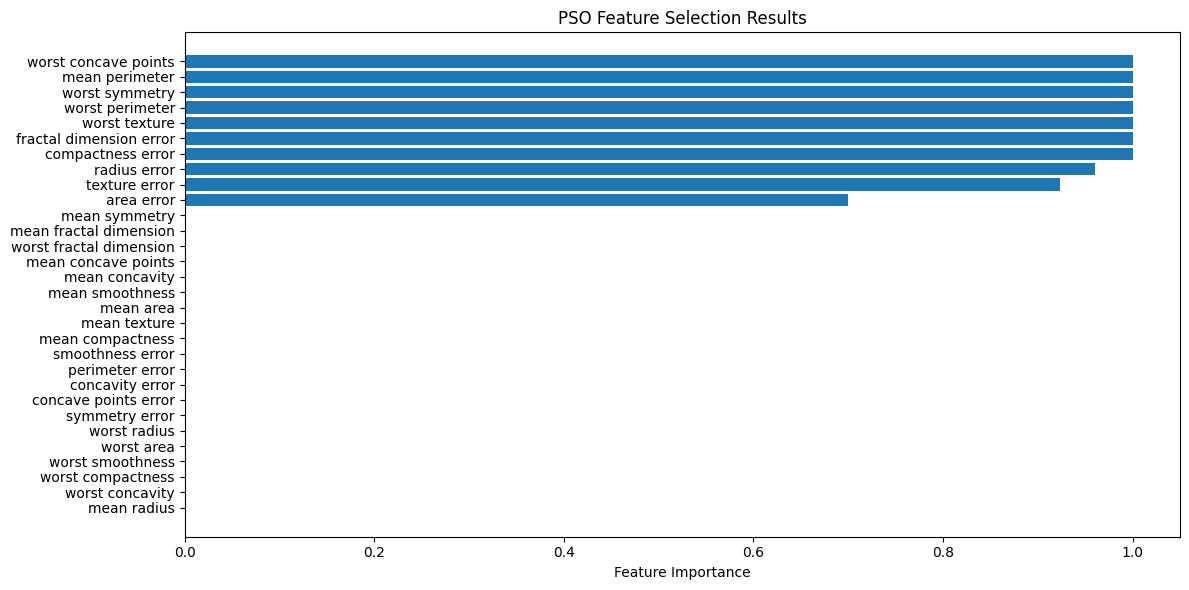

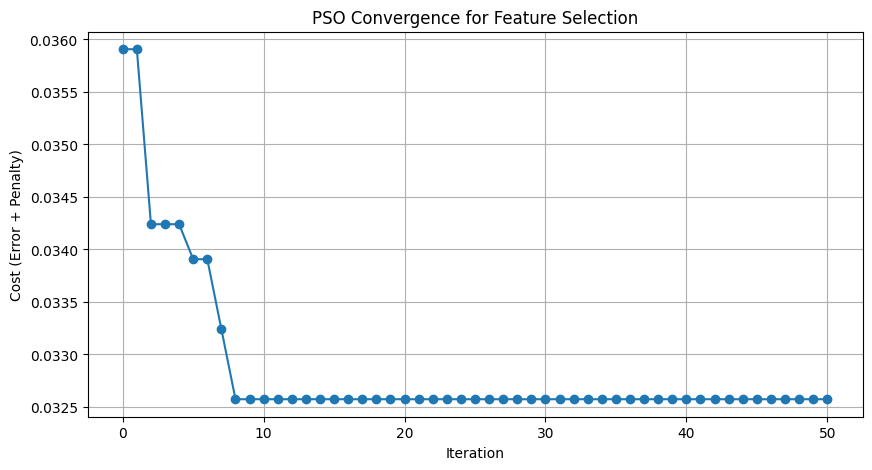

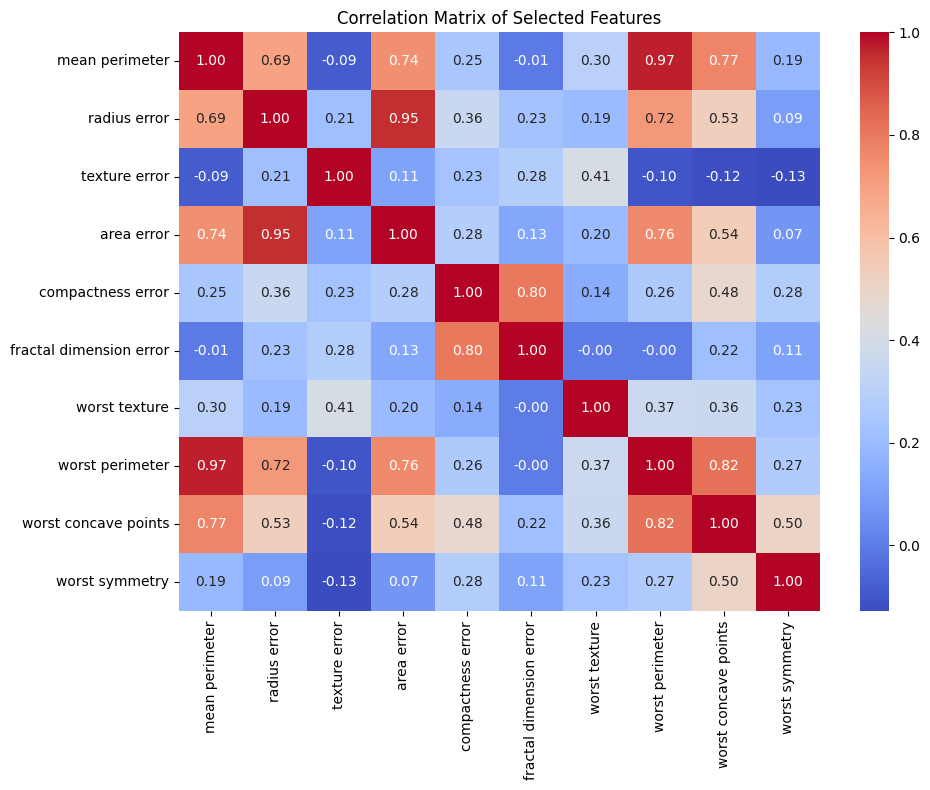

In [25]:
selected_features, feature_names = breast_cancer_feature_selection()